<a href="https://colab.research.google.com/github/HaoWu0607/MAE-2024/blob/main/671project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step1: Import Packages**

In [ ]:
import numpy as np
import pandas as pd
import re
import tqdm
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,balanced_accuracy_score

**Step2: Data-preprocessing for training data-frame**

In [ ]:
#read csv for both test and train
path_test = '/content/test.csv'
path_train = '/content/train.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [ ]:
#get shape of the training data-frame
print(f'shape of original training set: {df_train.shape }')
#get shape of the test data-frame
print(f'shape of original test set: {df_test.shape }')

shape of original training set: (15441, 48)
shape of original test set: (6291, 47)


In [ ]:
print(f'data type of training set: \n {df_train.info()}')#get detailed info of the training data-frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15441 entries, 0 to 15440
Data columns (total 48 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            15441 non-null  int64  
 1   scrape_id                                     15441 non-null  int64  
 2   last_scraped                                  15441 non-null  object 
 3   name                                          15441 non-null  object 
 4   description                                   15216 non-null  object 
 5   picture_url                                   15441 non-null  object 
 6   host_id                                       15441 non-null  int64  
 7   host_name                                     15441 non-null  object 
 8   host_since                                    15441 non-null  object 
 9   host_is_superhost                             15013 non-null 

In [ ]:
df_train.isnull().sum() #check null value of the data set

id                                                0
scrape_id                                         0
last_scraped                                      0
name                                              0
description                                     225
picture_url                                       0
host_id                                           0
host_name                                         0
host_since                                        0
host_is_superhost                               428
host_listings_count                               0
host_total_listings_count                         0
host_verifications                                0
host_has_profile_pic                              0
host_identity_verified                            0
neighbourhood_cleansed                            0
neighbourhood_group_cleansed                      0
latitude                                          0
longitude                                         0
property_typ

In [ ]:
#drop na value, as the proportion of missed is low
df_train = df_train.dropna(subset=['host_is_superhost','beds','bathrooms_text','description'])

In [ ]:
#select features that will probobaly have effects on the price
target_var = ['name',
              'host_id',
              'property_type',
              'neighbourhood_cleansed',
              'description',
              'host_since',
              'host_is_superhost',
              'host_verifications',
              'host_has_profile_pic',
              'host_identity_verified',
              'neighbourhood_group_cleansed',
              'room_type',
              'accommodates',
              'bathrooms_text',
              'beds',
              'amenities',
              'latitude',
              'longitude',
              'price',
              'host_listings_count',
              'has_availability',
              'instant_bookable',
              'number_of_reviews',
              'availability_30',
              'availability_60',
              'availability_90',
              'availability_365',
              'minimum_nights',
              'maximum_nights',
              'minimum_minimum_nights',
              'minimum_maximum_nights',
              'minimum_nights_avg_ntm',
              'maximum_nights_avg_ntm',
              'calculated_host_listings_count',
              'calculated_host_listings_count_entire_homes',
              'calculated_host_listings_count_private_rooms',
              'calculated_host_listings_count_shared_rooms'
        ]
df_train = df_train[target_var]

Step 2.1 Feature engineering for 'description'

In [ ]:
# sentiment_score = []
# df_train['description']

In [ ]:
# from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# # Assuming df_train is your DataFrame with a 'text_column' containing text data
# # Replace 'text_column' with the actual column name

# # Example: Fill NaN values with an empty string
# df_train['description'] = df_train['description'].fillna('')

# # Create a SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

# # Function to calculate sentiment score using SentimentIntensityAnalyzer
# def calculate_sentiment(text):
#     return sia.polarity_scores(text)['compound']

# df_train['description_count'] = df_train['description'].apply(lambda x: len(x.split()))
# # Apply the function to create a new column 'sentiment_score'
# df_train['sentiment_score'] = df_train['description'].apply(calculate_sentiment)

In [ ]:
df_train = df_train.drop('description',axis=1)

Step2.1 Data-Cleaning for 'host_verifications'

In [ ]:
#check types of the verication
df_train['host_verifications'].unique()

array(["['email', 'phone']", "['email', 'phone', 'work_email']",
       "['phone']", "['phone', 'work_email']", "['email']", '[]',
       "['email', 'work_email']"], dtype=object)

In [ ]:
#apply one hot encoding for 'host_verifications'
methods = ['email','phone','work_email']
for method in methods:

    df_train[method] = df_train['host_verifications'].apply(lambda x: 1 if method in x else 0)

In [ ]:
#sanity check
df_train[['email','phone','work_email','host_verifications']]

,email,phone,work_email,host_verifications
0,1,1,0,"['email', 'phone']"
1,1,1,0,"['email', 'phone']"
2,1,1,1,"['email', 'phone', 'work_email']"
3,1,1,0,"['email', 'phone']"
4,1,1,0,"['email', 'phone']"
...,...,...,...,...
15434,1,1,0,"['email', 'phone']"
15435,1,1,0,"['email', 'phone']"
15436,0,1,0,['phone']
15438,1,1,0,"['email', 'phone']"


Step2.2 Data-Cleaning for 'amenities'

In [ ]:
df_train['amenities_list'] = df_train['amenities'].str.split(',')

# Use explode to create a new row for each amenity
df_amenities = df_train.explode('amenities_list')

# Get unique values
unique_amenities = df_amenities['amenities_list'].unique()

In [ ]:
print(f'there are {len(unique_amenities)} of attributes in train df')

there are 4595 of attributes in train df


In [ ]:
#check frequency of top 10 amentities
top_amenities = df_amenities['amenities_list'].value_counts().head(10)
top_amenities

 "Kitchen"                  13203
 "Wifi"                     13170
 "Smoke alarm"              13097
 "Essentials"               12410
 "Hangers"                  11400
 "Hot water"                10722
 "Iron"                     10261
 "Dishes and silverware"    10200
 "Shampoo"                   9935
 "Hair dryer"                9882
Name: amenities_list, dtype: int64

In [ ]:
#check frequency of tail 4300 amentities
top_amenities = df_amenities['amenities_list'].value_counts().tail(4300)
top_amenities

 "Samsung stainless steel gas stove"                                               83
 french press                                                                      83
 "Kitchen"]                                                                        82
 "Marina view"                                                                     82
 "Free residential garage on premises \u2013 2 spaces"                             82
                                                                                   ..
 "Handmade Bluetooth sound system"                                                  1
 "Kitchen aid  refrigerator"                                                        1
["54\" HDTV with Amazon Prime Video                                                 1
 "Fast wifi \u2013 331 Mbps"                                                        1
 "LG French Door. Water Dispenser not working but Ice Maker is OK refrigerator"     1
Name: amenities_list, Length: 4300, dtype: int64

In [ ]:
#using attributes ranked between 10 to 40
top_amenities = df_amenities['amenities_list'].value_counts().head(50).tail(10).index

In [ ]:
# top_amenities = ['Sound system', 'TV', 'Wifi', 'Air conditioning' ,
#           'Pool', 'Washer', 'Dryer',
#           'BBQ grill', 'Clothing storage', 'Kitchen',
#           'Stove', 'Bathtub', 'Microwave','Refrigerator',
#           'Freezer','Mini fridge']
top_amenities = ["Hair dryer", "Cooking basics", "Refrigerator", "Microwave",
        "Bed linens", "Dedicated workspace", "Fire extinguisher",
        "Air conditioning", "First aid kit"]
#one hot encoding for the selected amentities
for attr in top_amenities:
     indicator = attr.replace(' ', '_').lower()
     df_train[indicator] = np.where(df_train['amenities'].str.contains(attr, case=False), 1, 0)


In [ ]:
#create amentities_count as a new feature
df_train['amenities_count'] = df_train['amenities'].apply(lambda x: len(eval(x)))

# # Display the DataFrame with the new 'amenities_count' column
print(df_train[['amenities', 'amenities_count']])

df_train = df_train.drop('amenities_list',axis = 1)
df_train = df_train.drop('amenities',axis = 1)

                                               amenities  amenities_count
0      ["Stove", "Iron", "Window guards", "Smoking al...               35
1      ["Stove", "Carbon monoxide alarm", "Iron", "Fr...               58
2      ["Stove", "Carbon monoxide alarm", "Iron", "Ho...               28
3      ["Free parking on premises", "Smoke alarm", "C...               13
4      ["Carbon monoxide alarm", "Iron", "Air conditi...               23
...                                                  ...              ...
15434  ["Carbon monoxide alarm", "Iron", "Stainless s...               52
15435  ["Courtyard view", "Carbon monoxide alarm", "I...               51
15436  ["Free parking on premises", "Smoke alarm", "D...               20
15438  ["Stove", "Carbon monoxide alarm", "Iron", "Fr...               52
15440  ["Stove", "Carbon monoxide alarm", "Single ove...               34

[14675 rows x 2 columns]


Step2.3 Data-Cleaning for 'name'

in this part, I will extract number of bedroom, whether the room is a studio or not and the star rate. The reason why I'm not using numbers of bed and bathroom is that they will are listed on the different columns

In [ ]:
#check types of data in the column
df_train['name'][1]

'Rental unit in Venice · ★4.74 · 2 bedrooms · 2 beds · 2 baths'

In [ ]:
#check whether the house is a studio or not, than apply one hot encoding
df_train['is_studio'] = df_train['name'].apply(lambda x: 1 if 'Studio' in x.split() else 0)

In [ ]:
#chekc number of houses which are studios
df_train['is_studio'].sum()

805

Mean price for studio: 1.0844720496894409
Mean price for non-studio: 1.998341744772891


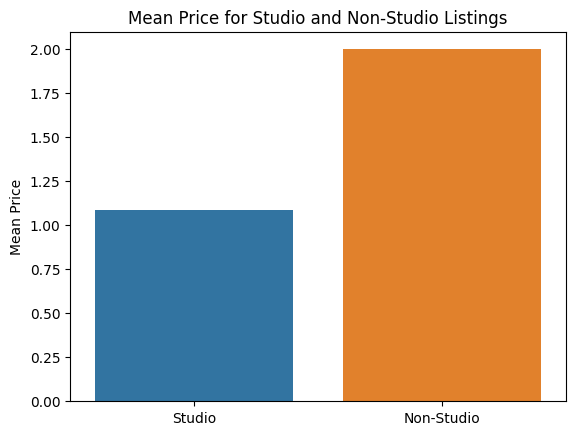

In [ ]:
#check correlation
rows_is_studio = df_train[df_train['is_studio'] == 1][['is_studio', 'price']]
rows_isnot_studio = df_train[df_train['is_studio'] == 0][['is_studio', 'price']]
mean_price_is_studio = rows_is_studio['price'].mean()
mean_price_isnot_studio = rows_isnot_studio['price'].mean()

# Print mean prices
print(f"Mean price for studio: {mean_price_is_studio}")
print(f"Mean price for non-studio: {mean_price_isnot_studio}")

# Plot the mean prices
sns.barplot(x=['Studio', 'Non-Studio'], y=[mean_price_is_studio, mean_price_isnot_studio])
plt.ylabel('Mean Price')
plt.title('Mean Price for Studio and Non-Studio Listings')
plt.show()

In [ ]:
df_train = df_train.drop('host_verifications',axis = 1)

In [ ]:
#extract number of bedrooms from name column
bedroom_list = []
# Define a regular expression pattern
pattern = r'(\d+)\s*bedrooms?'
for info in df_train['name'].values:

# Use re.search to find the match in the string
    match = re.search(pattern, info)

# If a match is found, extract the number of bedrooms
    if match:
        num_bedrooms = int(match.group(1))
    else:
        num_bedrooms = None

    bedroom_list.append(num_bedrooms)

df_train['num_bedrooms'] = bedroom_list

In [ ]:
#sanity check
df_train[['num_bedrooms','name']]

,num_bedrooms,name
0,1.0,Home in Torrance · 1 bedroom · 1 bed · 1 share...
1,2.0,Rental unit in Venice · ★4.74 · 2 bedrooms · 2...
2,3.0,Home in Avalon · ★5.0 · 3 bedrooms · 4 beds · ...
3,4.0,Home in Santa Clarita · 4 bedrooms · 5 beds · ...
4,1.0,Hotel in Los Angeles · ★New · 1 bedroom · 1 be...
...,...,...
15434,4.0,Home in Diamond Bar · 4 bedrooms · 4 beds · 2 ...
15435,1.0,Condo in Santa Monica · ★4.86 · 1 bedroom · 1 ...
15436,2.0,Rental unit in Glendale · 2 bedrooms · 2 beds ...
15438,1.0,Rental unit in Los Angeles · 1 bedroom · 1 bed...


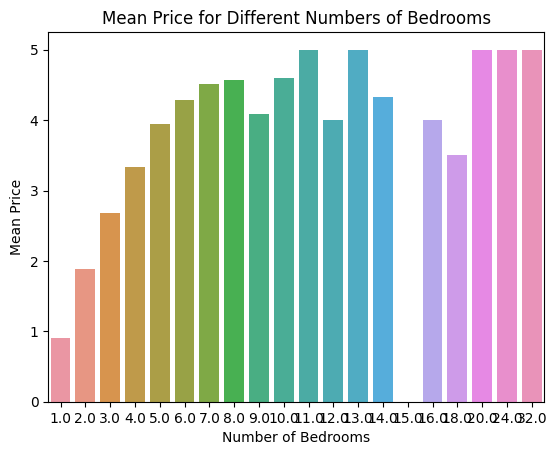

In [ ]:
#correlation check
bedroom_categories = df_train['num_bedrooms'].unique()

mean_prices = []

for num_bedrooms in bedroom_categories:
    rows = df_train[df_train['num_bedrooms'] == num_bedrooms][['num_bedrooms', 'price']]
    mean_price = rows['price'].mean()
    mean_prices.append(mean_price)

# Plot the mean prices
sns.barplot(x=bedroom_categories, y=mean_prices)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Mean Price')
plt.title('Mean Price for Different Numbers of Bedrooms')
plt.show()

In [ ]:
#sanity check
nan_values = df_train[df_train['num_bedrooms'].isna()][['name', 'num_bedrooms']]
nan_values

,name,num_bedrooms
9,Boutique hotel in Beverly Hills · Studio · 2 b...,NaN
15,Rental unit in Malibu · ★5.0 · Studio · 2 beds...,NaN
41,Rental unit in Los Angeles · Studio · 1 bed · ...,NaN
52,Rental unit in Los Angeles · ★5.0 · Studio · 1...,NaN
69,Guesthouse in Arcadia · Studio · 1 bed · 1 bath,NaN
...,...,...
15313,Guesthouse in Malibu · ★4.95 · Studio · 2 beds...,NaN
15380,Rental unit in Los Angeles · Studio · 1 bed · ...,NaN
15397,Rental unit in Los Angeles · ★New · Studio · 1...,NaN
15414,Boutique hotel in Los Angeles · Studio · 1 bed...,NaN


In [ ]:
#fill na with 0
df_train['num_bedrooms'] = df_train['num_bedrooms'].fillna(0)

In [ ]:
#extract star from name column
star_list = []
for info in df_train['name'].values:
    pattern = r'★([\d.]+)'
    match = re.search(pattern, info)
    if match:
        rating = match.group(1)
    else:
        rating = None
    star_list.append(rating)

df_train['star'] = star_list

In [ ]:
#sanity check
df_train[['star','name']]

,star,name
0,None,Home in Torrance · 1 bedroom · 1 bed · 1 share...
1,4.74,Rental unit in Venice · ★4.74 · 2 bedrooms · 2...
2,5.0,Home in Avalon · ★5.0 · 3 bedrooms · 4 beds · ...
3,None,Home in Santa Clarita · 4 bedrooms · 5 beds · ...
4,None,Hotel in Los Angeles · ★New · 1 bedroom · 1 be...
...,...,...
15434,None,Home in Diamond Bar · 4 bedrooms · 4 beds · 2 ...
15435,4.86,Condo in Santa Monica · ★4.86 · 1 bedroom · 1 ...
15436,None,Rental unit in Glendale · 2 bedrooms · 2 beds ...
15438,None,Rental unit in Los Angeles · 1 bedroom · 1 bed...


In [ ]:
df_train['star'] = df_train['star'].astype(float)

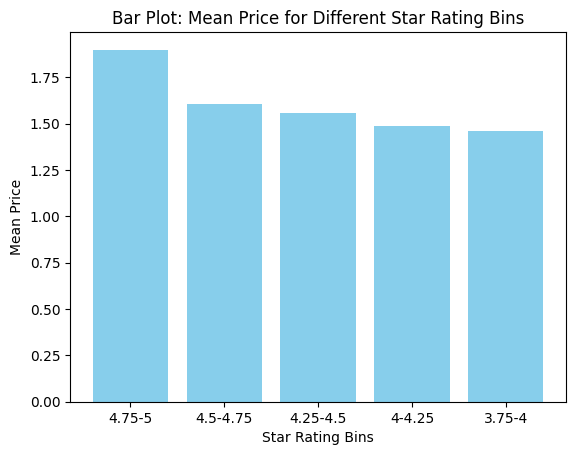

In [ ]:
# check correlation
mean_price_bin1 = df_train[(df_train['star'] >= 4.75) & (df_train['star'] <= 5.0)]['price'].mean()
mean_price_bin2= df_train[(df_train['star'] >= 4.5) & (df_train['star'] <= 4.75)]['price'].mean()
mean_price_bin3 = df_train[(df_train['star'] >= 4.25) & (df_train['star'] <= 4.5)]['price'].mean()
mean_price_bin4 = df_train[(df_train['star'] >= 4) & (df_train['star'] <= 4.25)]['price'].mean()
mean_price_bin5 = df_train[(df_train['star'] >= 3.75) & (df_train['star'] <= 4)]['price'].mean()
bin_list = [mean_price_bin1,mean_price_bin2,mean_price_bin3,mean_price_bin4,mean_price_bin5]

# Plot the bar chart
plt.bar(['4.75-5', '4.5-4.75', '4.25-4.5', '4-4.25', '3.75-4'], bin_list, color='skyblue')
plt.xlabel('Star Rating Bins')
plt.ylabel('Mean Price')
plt.title('Bar Plot: Mean Price for Different Star Rating Bins')
plt.show()

In [ ]:
#fill star score with outlier 50
df_train['star'].fillna(50,inplace = True)

In [ ]:
df_train = df_train.drop('name',axis = 1)

Step2.3 Data-Cleaning for 'host_since'

In [ ]:
#check data type in host_since column
df_train['host_since']

0        2018-07-27
1        2013-07-19
2        2019-06-24
3        2021-11-01
4        2023-02-20
            ...    
15434    2023-02-19
15435    2021-11-23
15436    2020-09-10
15438    2015-10-09
15440    2015-09-08
Name: host_since, Length: 14675, dtype: object

In [ ]:
#convert datetime data to number of days since the hosting
df_train['host_since'] = pd.to_datetime(df_train['host_since'])
target_date = pd.to_datetime('2023-12-2')
df_train['days_since_hosting'] = (target_date - df_train['host_since']).dt.days

In [ ]:
#sanity check
df_train['days_since_hosting']

0        1954
1        3788
2        1622
3         761
4         285
         ... 
15434     286
15435     739
15436    1178
15438    2976
15440    3007
Name: days_since_hosting, Length: 14675, dtype: int64

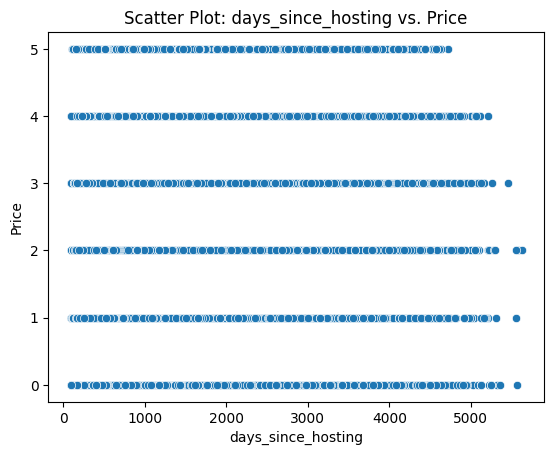

Correlation Coefficient: -0.022524502412475972


In [ ]:
#correlation check
sns.scatterplot(x='days_since_hosting', y='price', data=df_train)
plt.xlabel('days_since_hosting')
plt.ylabel('Price')
plt.title('Scatter Plot: days_since_hosting vs. Price')
plt.show()
correlation_coefficient = df_train['days_since_hosting'].corr(df_train['price'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Hence, this feature seems useless in the price prediction

In [ ]:
#df_train = df_train.drop(['days_since_hosting','host_since'],axis = 1)
df_train = df_train.drop(['host_since'],axis = 1)

Step2.4 Data Cleaning for bathrooms_text

In [ ]:
#check data type
df_train['bathrooms_text'].unique()

array(['1 shared bath', '2 baths', '2.5 baths', '1 bath', '5 baths',
       '3.5 baths', '1 private bath', '3 baths', '2 shared baths',
       '6 baths', '4 baths', '1.5 baths', '5.5 baths', '0 baths',
       '4.5 baths', '3 shared baths', '8.5 baths', '2.5 shared baths',
       '7 baths', '7.5 baths', '1.5 shared baths', '6.5 baths', '8 baths',
       '11 shared baths', '10 baths', '10.5 baths', 'Shared half-bath',
       '3.5 shared baths', '0 shared baths', '6 shared baths', '21 baths',
       'Half-bath', '12 baths', '8 shared baths', '15 baths',
       '4 shared baths', '11 baths', '9 baths', '5 shared baths',
       '11.5 baths', '16 baths', '9.5 baths', '13 baths', '27 baths',
       '25 baths', 'Private half-bath', '36 baths', '13.5 baths'],
      dtype=object)

In [ ]:
#check whether the bathroom is shared or not
df_train['share_indicator'] = np.where(df_train['bathrooms_text'].str.contains('share', case=False), 1, 0)
df_train[['share_indicator', 'bathrooms_text']].head(15)

,share_indicator,bathrooms_text
0,1,1 shared bath
1,0,2 baths
2,0,2 baths
3,0,2.5 baths
4,0,1 bath
6,0,5 baths
7,0,3.5 baths
8,0,2.5 baths
9,0,1 private bath
10,0,2 baths


Mean price for studio: 0.3840985442329227
Mean price for non-studio: 2.0495573937019302


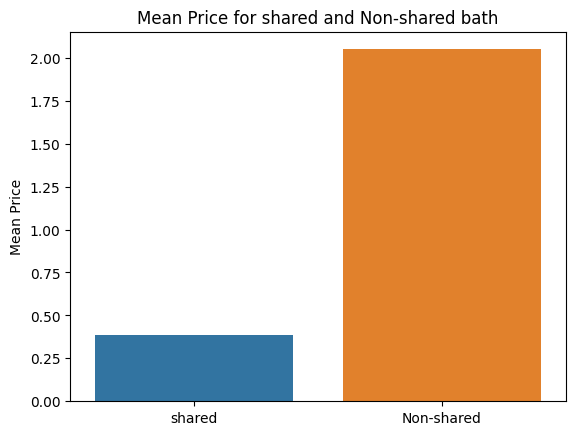

In [ ]:
#check correlation
rows_is_shared = df_train[df_train['share_indicator'] == 1][['share_indicator', 'price']]
rows_isnot_shared = df_train[df_train['share_indicator'] == 0][['share_indicator', 'price']]
mean_price_is_shared = rows_is_shared['price'].mean()
mean_price_isnot_shared = rows_isnot_shared['price'].mean()

# Print mean prices
print(f"Mean price for studio: {mean_price_is_shared}")
print(f"Mean price for non-studio: {mean_price_isnot_shared}")

# Plot the mean prices
sns.barplot(x=['shared', 'Non-shared'], y=[mean_price_is_shared, mean_price_isnot_shared])
plt.ylabel('Mean Price')
plt.title('Mean Price for shared and Non-shared bath')
plt.show()

In [ ]:
#extract number of baths from 'bathrooms_text' column
df_train['num_baths'] = df_train['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)

In [ ]:
#check missing value
df_train['num_baths'].isnull().sum()

24

In [ ]:
#check what happend on nan value
df_train[df_train['num_baths'].isna()][['bathrooms_text', 'num_baths']]

,bathrooms_text,num_baths
1180,Shared half-bath,NaN
2083,Shared half-bath,NaN
3310,Half-bath,NaN
3443,Shared half-bath,NaN
3757,Shared half-bath,NaN
4083,Half-bath,NaN
4158,Shared half-bath,NaN
4444,Half-bath,NaN
5353,Half-bath,NaN
5471,Half-bath,NaN


In [ ]:
#fill nan with 0.5 based on above
df_train['num_baths'] = df_train['num_baths'].fillna(0.5)

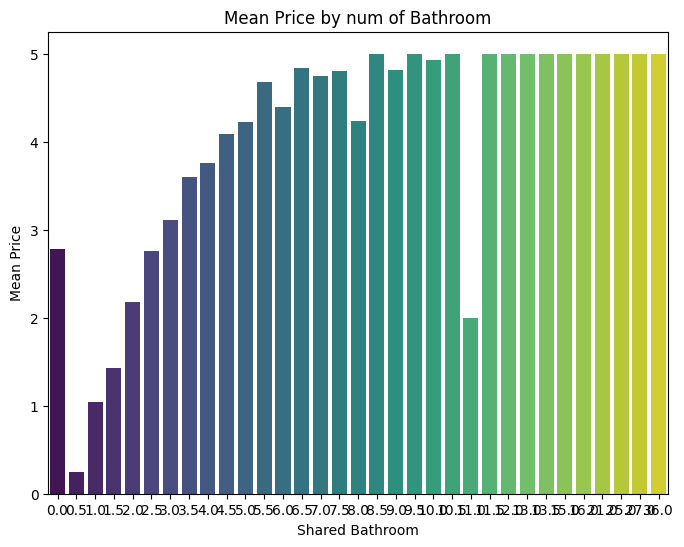

In [ ]:
#correlation check
mean_price_by_num_bathroom = df_train.groupby('num_baths')['price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(x='num_baths', y='price', data=mean_price_by_num_bathroom, palette='viridis')
plt.title('Mean Price by num of Bathroom')
plt.xlabel('Shared Bathroom')
plt.ylabel('Mean Price')
plt.show()

In [ ]:
df_train = df_train.drop('bathrooms_text',axis=1)

Step 2.5 Turns the T/F label to binary 0,1 label

In [ ]:
#one hot encoding for t/f columns
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_train['host_is_superhost'] = label_encoder.fit_transform(df_train['host_is_superhost'])
df_train['host_has_profile_pic']= label_encoder.fit_transform(df_train['host_has_profile_pic'])
df_train['host_identity_verified']= label_encoder.fit_transform(df_train['host_identity_verified'])
df_train['instant_bookable']= label_encoder.fit_transform(df_train['instant_bookable'])
df_train['has_availability']= label_encoder.fit_transform(df_train['has_availability'])

Step 2.6 Data cleaning for 'room_type'

In [ ]:
df_train['room_type'].unique()

array(['Shared room', 'Entire home/apt', 'Private room', 'Hotel room'],
      dtype=object)

In [ ]:
#by common sense, the price of entire home > Hotel room  > private room  > shared room
df_train['room_type'] = df_train['room_type'].replace({'Entire home/apt': 4,'Hotel room': 3, 'Private room': 2,  'Shared room': 1})
df_train['room_type'].unique()

array([1, 4, 2, 3])

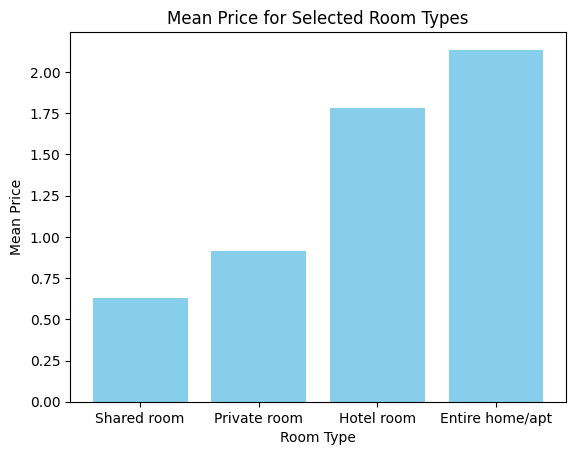

In [ ]:
#check correlation stat for room type
room_types_to_plot = [1, 2, 3, 4]

# Calculate mean prices for each room type and plot bar chart
mean_prices = df_train[df_train['room_type'].isin(room_types_to_plot)].groupby('room_type')['price'].mean()
room_type_labels = ['Shared room','Private room', 'Hotel room', 'Entire home/apt']

plt.bar(mean_prices.index, mean_prices, color='skyblue')
plt.xlabel('Room Type')
plt.ylabel('Mean Price')
plt.title('Mean Price for Selected Room Types')
plt.xticks(mean_prices.index, room_type_labels)
plt.show()

Step 2.7 Data cleaning for 'neighbourhood_group_cleansed','neighbourhood_cleansed' and 'property_type'

In [ ]:
df_train['neighbourhood_group_cleansed'].unique()

array(['City of Los Angeles', 'Other Cities', 'Unincorporated Areas'],
      dtype=object)

In [ ]:

#by common sense, the price of City of Los Angeles > Other Cities > Unincorporated Areas

df_train['neighbourhood_group_cleansed'] = df_train['neighbourhood_group_cleansed'].replace({'City of Los Angeles': 3, 'Other Cities': 2,'Unincorporated Areas':1})

# Display the DataFrame with the updated column
print(df_train['neighbourhood_group_cleansed'])

0        3
1        3
2        2
3        2
4        3
        ..
15434    2
15435    2
15436    2
15438    3
15440    3
Name: neighbourhood_group_cleansed, Length: 14675, dtype: int64


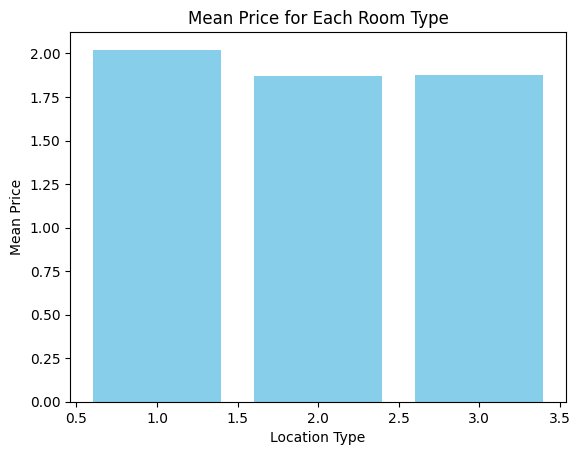

In [ ]:
#correlation check
plt.bar(df_train['neighbourhood_group_cleansed'].unique(), df_train.groupby('neighbourhood_group_cleansed')['price'].mean(), color='skyblue')
plt.xlabel('Location Type')
plt.ylabel('Mean Price')
plt.title('Mean Price for Each Room Type')
plt.show()

In [ ]:
# plt.boxplot([df_train[df_train['neighbourhood_group_cleansed'] == group]['price'] for group in df_train['neighbourhood_group_cleansed'].unique()],
#             labels=df_train['neighbourhood_group_cleansed'].unique(),
#             patch_artist=True,
#             showmeans=True,
#             meanprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'red'})

# plt.xlabel('Neighborhood Group')
# plt.ylabel('Price')
# plt.title('Distribution of Prices for Each Neighborhood Group')
# plt.show()

In [ ]:
df_train = df_train.drop('neighbourhood_group_cleansed',axis = 1)

In [ ]:
df_train['neighbourhood_cleansed'].value_counts() #check different neighbourhood types

Venice            727
Santa Monica      558
Long Beach        549
West Hollywood    535
Hollywood         515
                 ... 
Citrus              1
Val Verde           1
Rolling Hills       1
Angeles Crest       1
Elizabeth Lake      1
Name: neighbourhood_cleansed, Length: 258, dtype: int64

In [ ]:
#label encoding based on the mean price calculated by the group method
mean_price_by_neighbourhood = df_train.groupby('neighbourhood_cleansed')['price'].mean()
#least_frequent_categories = mean_price_by_neighbourhood.nsmallest(70).index
rank_by_neighbourhood = mean_price_by_neighbourhood.rank()

#rank_by_neighbourhood.loc[least_frequent_categories] = -1

df_train['neighbourhood_cleansed'] = df_train['neighbourhood_cleansed'].map(rank_by_neighbourhood)

print(df_train['neighbourhood_cleansed'])


0         67.0
1        212.0
2        240.0
3        191.0
4        215.0
         ...  
15434    160.0
15435    173.0
15436    138.0
15438    123.0
15440    178.0
Name: neighbourhood_cleansed, Length: 14675, dtype: float64


In [ ]:
#sanity check
rank_by_neighbourhood

neighbourhood_cleansed
Acton              198.0
Adams-Normandie     27.5
Agoura Hills       180.0
Agua Dulce         246.0
Alhambra            72.0
                   ...  
Willowbrook        128.0
Wilmington         186.0
Windsor Square     105.5
Winnetka           148.0
Woodland Hills     211.0
Name: price, Length: 258, dtype: float64

In [ ]:
#label encoding based on the mean price calculated by the group method
mean_price_by_proptype = df_train.groupby('property_type')['price'].mean()

# Calculate the rank of mean prices within each neighborhood
rank_by_proptype = mean_price_by_proptype.rank()

# Display the result
print(rank_by_proptype)

df_train['property_type'] = df_train['property_type'].map(rank_by_proptype)

# Display the DataFrame with the 'price' column replaced by the rank
print(df_train['property_type'])

property_type
Barn                    45.0
Boat                    46.0
Camper/RV               30.0
Campsite                61.5
Casa particular         71.0
                        ... 
Shared room in villa    10.0
Tent                    39.0
Tiny home               44.0
Train                   39.0
Yurt                    78.0
Name: price, Length: 82, dtype: float64
0        22.0
1        47.0
2        67.0
3        67.0
4        74.0
         ... 
15434    67.0
15435    54.0
15436    47.0
15438    47.0
15440    47.0
Name: property_type, Length: 14675, dtype: float64


Step 2.8 visualize the geometric info represented by the dataset, and create downtown_distance column


<ipython-input-371-d35da7f089b2>:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  graph = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


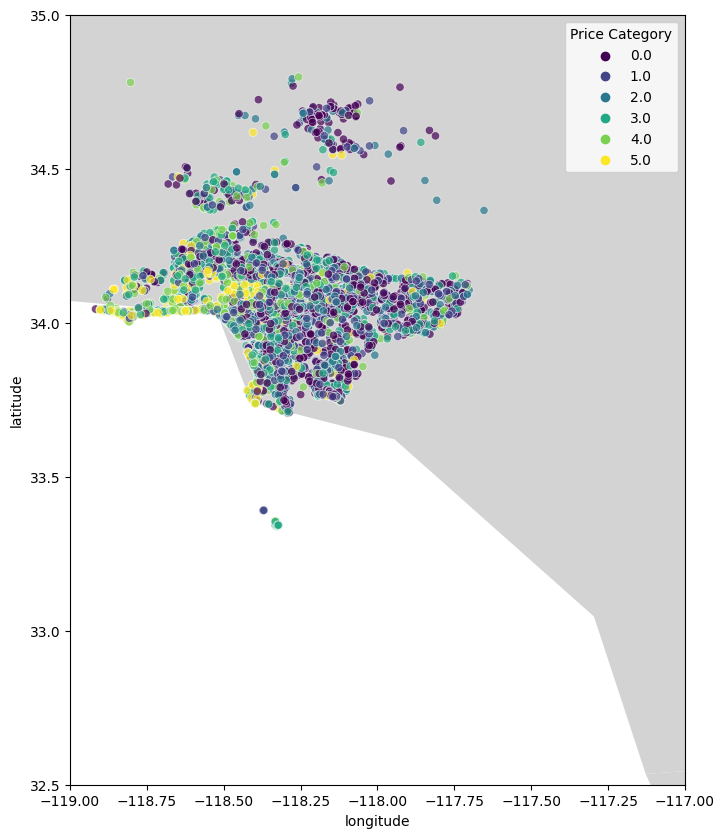

In [ ]:
import geopandas as gpd
# Create a GeoDataFrame
gdf_train = gpd.GeoDataFrame(df_train, geometry=gpd.points_from_xy(df_train.longitude, df_train.latitude))

# Set the latitude and longitude limits
latitude_min, latitude_max = 32.5, 35
longitude_min, longitude_max = -119, -117

# Filter the GeoDataFrame based on the area of interest
gdf_area_of_interest = gdf_train[(gdf_train.latitude >= latitude_min) & (gdf_train.latitude <= latitude_max)
                                 & (gdf_train.longitude >= longitude_min) & (gdf_train.longitude <= longitude_max)]

# Create a scatter plot
fig, ax = plt.subplots(figsize=(15, 10))
graph = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
graph.plot(ax=ax, color='lightgrey')

sns.scatterplot(x='longitude', y='latitude', hue='price', data=gdf_area_of_interest, palette='viridis', alpha=0.7, legend='full', ax=ax)

ax.legend(title='Price Category')

# Set x-axis and y-axis limits
ax.set_xlim(longitude_min, longitude_max)
ax.set_ylim(latitude_min, latitude_max)

plt.show()

In [ ]:
#add new column named 'distance_to_downtown' and calculate euclidean distance between downtown and house location using geometrical info
loc = np.array([34.052235, -118.243683])
dis_list = []

for i, j in zip(df_train['latitude'], df_train['longitude']):
    point1 = np.array([i, j])  # Use parentheses here
    distance = np.linalg.norm(point1 - loc)
    dis_list.append(distance)

df_train['distance_to_downtown'] = dis_list


check correlation for 'accomodates' and 'num_reviews'

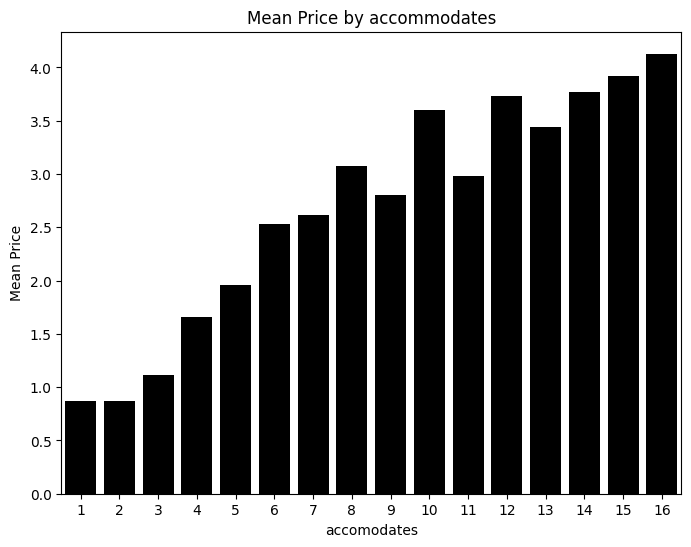

In [ ]:
#accomodates
mean_price_by_accommodates = df_train.groupby('accommodates')['price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(x='accommodates', y='price', data=mean_price_by_accommodates,color='black')
plt.title('Mean Price by accommodates')
plt.xlabel('accomodates')
plt.ylabel('Mean Price')
plt.show()

In [ ]:
df_train['number_of_reviews']

0         0
1        81
2         3
3         0
4         0
         ..
15434     0
15435     7
15436     2
15438     0
15440     0
Name: number_of_reviews, Length: 14675, dtype: int64

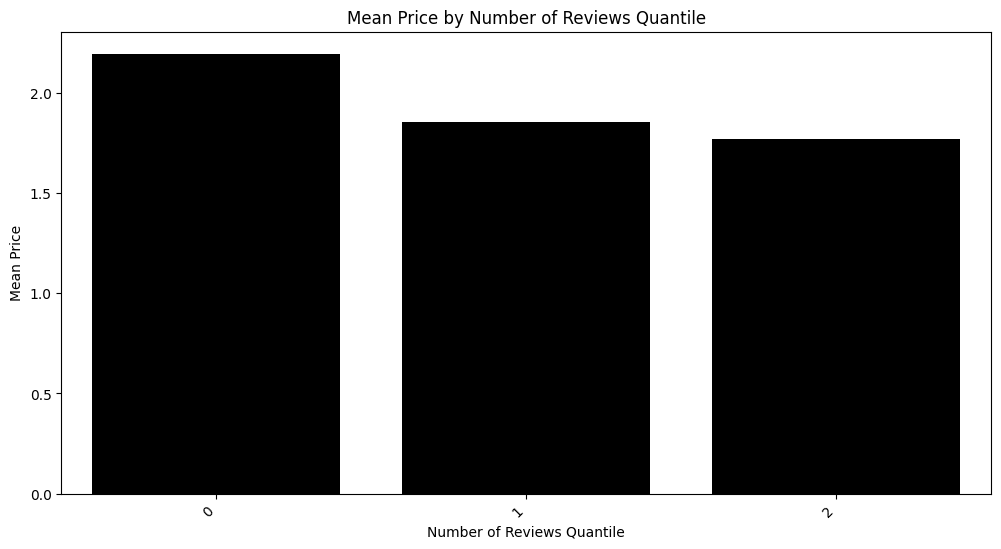

In [ ]:
#num_reviews
df_train['reviews_quantile'] = pd.qcut(df_train['number_of_reviews'], q = 3, labels=False)

# Group by 'reviews_quantile' and calculate mean price
mean_price_by_reviews_quantile = df_train.groupby('reviews_quantile')['price'].mean().reset_index()

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='reviews_quantile', y='price', data=mean_price_by_reviews_quantile, color='black')
plt.title('Mean Price by Number of Reviews Quantile')
plt.xlabel('Number of Reviews Quantile')
plt.ylabel('Mean Price')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

df_train = df_train.drop('reviews_quantile',axis = 1)

In [ ]:
df_train = df_train.dropna() #drop all na for fitting

In [ ]:
df_train.shape #check final shape

(14675, 50)

In [ ]:
df_train.isnull().sum()#sanity check

host_id                                         0
property_type                                   0
neighbourhood_cleansed                          0
host_is_superhost                               0
host_has_profile_pic                            0
host_identity_verified                          0
room_type                                       0
accommodates                                    0
beds                                            0
latitude                                        0
longitude                                       0
price                                           0
host_listings_count                             0
has_availability                                0
instant_bookable                                0
number_of_reviews                               0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0


Step3 Model1 Random Forest

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
X = df_train.drop('price', axis=1)
y = df_train['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 52)

# Train the Random Forest Model
#rf_model = RandomForestClassifier(n_estimators=300, max_features = 0.3, max_samples = 0.6, max_depth = 18, ccp_alpha=0.001, random_state = 45)
rf_model = RandomForestClassifier(n_estimators=350, max_features =0.2 , random_state = 45) #10 feature version 55.8

rf_model.fit(X_train, y_train)

# Make Predictions on Train and Test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate Train Accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f'Training Accuracy: {train_accuracy}')

# Calculate Test Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy}')

# Print Classification Report for Test Set
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))
# Print Variable Importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print("Variable Importance:")
print(feature_importance)

Training Accuracy: 0.9998296422487223
Test Accuracy: 0.5965928449744463
Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.76      0.87      0.81       810
         1.0       0.51      0.50      0.50       534
         2.0       0.44      0.34      0.38       491
         3.0       0.49      0.56      0.52       524
         4.0       0.55      0.47      0.51       348
         5.0       0.81      0.66      0.73       228

    accuracy                           0.60      2935
   macro avg       0.59      0.57      0.58      2935
weighted avg       0.59      0.60      0.59      2935

Variable Importance:
                                         Feature  Importance
2                         neighbourhood_cleansed    0.064393
47                                     num_baths    0.059011
10                                     longitude    0.053501
9                                       latitude    0.049797
7                        

In [ ]:
#balanced accurcy for random forest model
balanced_acc_randomforest = balanced_accuracy_score(y_test, y_test_pred)
print(f'balanced accurcy for random forest model:{balanced_acc_randomforest}')

balanced accurcy for random forest model:0.5680106663399063


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_features': [0.3, 0.4, 0.5],
}

rf_model_grid = RandomForestClassifier(random_state = 45)

grid_search = GridSearchCV(estimator=rf_model_grid, param_grid=param_grid, cv=5, scoring='accuracy',verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters found by the grid search
print("Best Parameters:", grid_search.best_params_)

# Get the mean cross-validated score of the best_estimator
mean_accuracy = grid_search.best_score_
print(f'Mean Cross-Validated Accuracy: {mean_accuracy}')

# Make predictions using the best model
best_rf_model = grid_search.best_estimator_
y_test_pred_best = best_rf_model.predict(X_test)

# Calculate Test Accuracy using the best model
test_accuracy_best = accuracy_score(y_test, y_test_pred_best)
print(f'Test Accuracy (Best Model): {test_accuracy_best}')

# Print Classification Report for Test Set using the best model
print("Classification Report (Test Set - Best Model):")
print(classification_report(y_test, y_test_pred_best))

# Print Variable Importance for the best model
feature_importance_best = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf_model.feature_importances_})
feature_importance_best = feature_importance_best.sort_values(by='Importance', ascending=False)

print("Variable Importance (Best Model):")
print(feature_importance_best)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................max_features=0.3, n_estimators=200; total time=  11.0s
[CV] END .................max_features=0.3, n_estimators=200; total time=  11.0s
[CV] END .................max_features=0.3, n_estimators=200; total time=   9.7s
[CV] END .................max_features=0.3, n_estimators=200; total time=  10.8s
[CV] END .................max_features=0.3, n_estimators=200; total time=  11.0s
[CV] END .................max_features=0.3, n_estimators=250; total time=  13.5s
[CV] END .................max_features=0.3, n_estimators=250; total time=  13.3s
[CV] END .................max_features=0.3, n_estimators=250; total time=  13.3s
[CV] END .................max_features=0.3, n_estimators=250; total time=  13.2s
[CV] END .................max_features=0.3, n_estimators=250; total time=  13.0s
[CV] END .................max_features=0.3, n_estimators=300; total time=  16.4s
[CV] END .................max_features=0.3, n_est

Model2 : Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create the AdaBoostClassifier with predefined hyperparameters
adaboost_model = AdaBoostClassifier(learning_rate = 0.5,n_estimators=150,random_state=45)

# Fit the AdaBoost model to the training data
adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred_adaboost = adaboost_model.predict(X_test)

# Calculate Test Accuracy
test_accuracy_adaboost = accuracy_score(y_test, y_test_pred_adaboost)
print(f'Test Accuracy (AdaBoost): {test_accuracy_adaboost}')

# Print Classification Report for Test Set
print("Classification Report (Test Set - AdaBoost):")
print(classification_report(y_test, y_test_pred_adaboost))

Test Accuracy (AdaBoost): 0.5073253833049404
Classification Report (Test Set - AdaBoost):
              precision    recall  f1-score   support

         0.0       0.70      0.83      0.76       810
         1.0       0.40      0.35      0.37       534
         2.0       0.31      0.21      0.25       491
         3.0       0.42      0.56      0.48       524
         4.0       0.40      0.32      0.35       348
         5.0       0.65      0.52      0.58       228

    accuracy                           0.51      2935
   macro avg       0.48      0.47      0.47      2935
weighted avg       0.49      0.51      0.49      2935



In [ ]:
#balanced accurcy for adaboost model
balanced_acc_adaboost = balanced_accuracy_score(y_test, y_test_pred_adaboost)
print(f'balanced accurcy for adaboost model:{balanced_acc_adaboost}')

balanced accurcy for adaboost model:0.4653338211401828


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Define the parameter grid for AdaBoost
param_grid_adaboost = {
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.01, 0.1, 0.5],
}

# Create the AdaBoostClassifier
adaboost_model_grid = AdaBoostClassifier(random_state=45)

# Create the GridSearchCV object for AdaBoost
grid_search_adaboost = GridSearchCV(estimator=adaboost_model_grid, param_grid=param_grid_adaboost, cv=5, scoring='accuracy',verbose = 2)

# Fit the grid search to the data
grid_search_adaboost.fit(X_train, y_train)


# Print the best parameters found by the grid search for AdaBoost
print("Best Parameters for AdaBoost:", grid_search_adaboost.best_params_)

# Get the mean cross-validated score of the best_estimator for AdaBoost
mean_accuracy_adaboost = grid_search_adaboost.best_score_
print(f'Mean Cross-Validated Accuracy for AdaBoost: {mean_accuracy_adaboost}')

# Make predictions using the best AdaBoost model
best_adaboost_model = grid_search_adaboost.best_estimator_
y_test_pred_best_adaboost = best_adaboost_model.predict(X_test)

# Calculate Test Accuracy using the best AdaBoost model
test_accuracy_best_adaboost = accuracy_score(y_test, y_test_pred_best_adaboost)
print(f'Test Accuracy (Best Model - AdaBoost): {test_accuracy_best_adaboost}')

# Print Classification Report for Test Set using the best AdaBoost model
print("Classification Report (Test Set - Best Model - AdaBoost):")
print(classification_report(y_test, y_test_pred_best_adaboost))



Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.5s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=75; total time=   1.7s
[CV] END ................learning_rate=0.01, n_estimators=75; total time=   1.8s
[CV] END ................learning_rate=0.01, n_estimators=75; total time=   1.8s
[CV] END ................learning_rate=0.01, n_estimators=75; total time=   2.5s
[CV] END ................learning_rate=0.01, n_estimators=75; total time=   2.2s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.3s
[CV] END ...............learning_rate=0.01, n_es

plot for hyperparameter tuning (random forest)


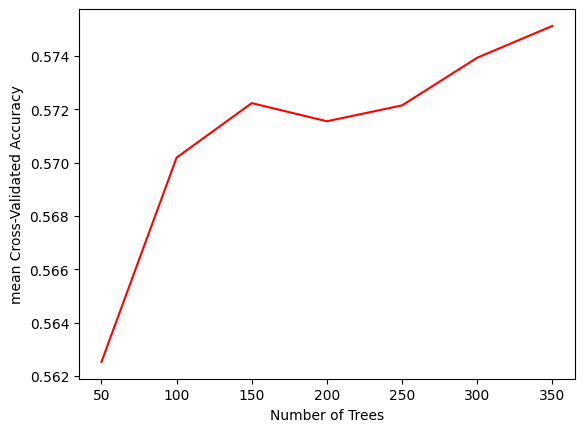

In [ ]:
#plot graph with respective to mean validation acc and n_estimators
rf = RandomForestClassifier(max_features=0.3, random_state=45)

acc_list = []
for num_estimate in range(50, 400, 50):

    rf.set_params(n_estimators= num_estimate)
    acc = cross_val_score(rf, X_train, y_train, cv=5).mean()
    acc_list.append(acc)

x = np.arange(50, 400, 50)
plt.plot(x, acc_list, 'r-')
plt.xlabel('Number of Trees')
plt.ylabel('mean Cross-Validated Accuracy')
plt.show()

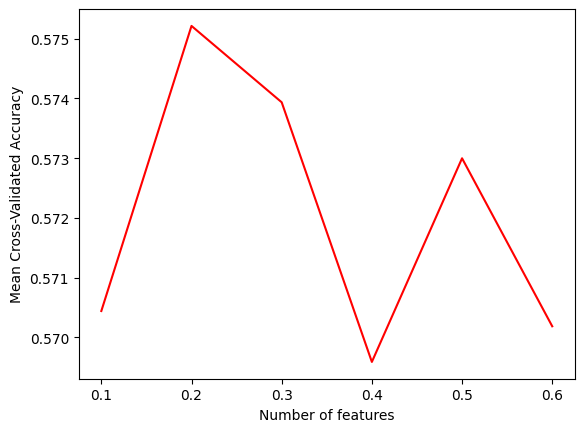

In [ ]:
#plot graph with respective to mean validation acc and max_featuress
rf = RandomForestClassifier(n_estimators=300, random_state=45)

acc_list = []
for num_features in range(1, 7):  # Adjust the range to [1, 2, 3, 4, 5, 6]

    rf.set_params(max_features=num_features / 10)
    acc = cross_val_score(rf, X_train, y_train, cv=5).mean()
    acc_list.append(acc)

x = np.arange(0.1, 0.7, 0.1)  # Adjust the range to [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.plot(x, acc_list, 'r-')
plt.xlabel('Number of features')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.show()

plot for hyperparameter tuning (Adaboost)

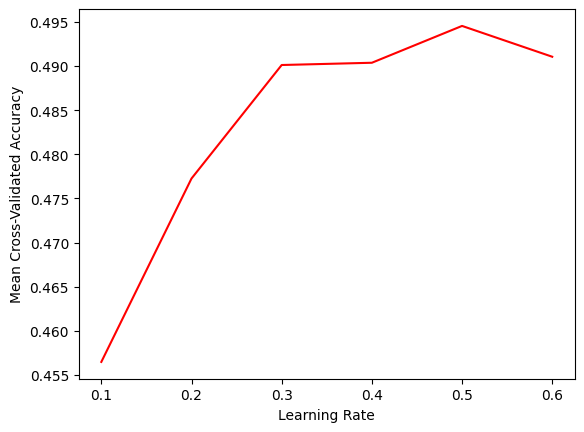

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(n_estimators=150, random_state=45)

acc_list = []
for lr in range(1, 7):  # Adjust the range to [1, 2, 3, 4, 5, 6]

    ada_boost.set_params(learning_rate=lr / 10)
    acc = cross_val_score(ada_boost, X_train, y_train, cv=5).mean()
    acc_list.append(acc)

x = np.arange(0.1, 0.7, 0.1)  # Adjust the range to [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
plt.plot(x, acc_list, 'r-')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.show()

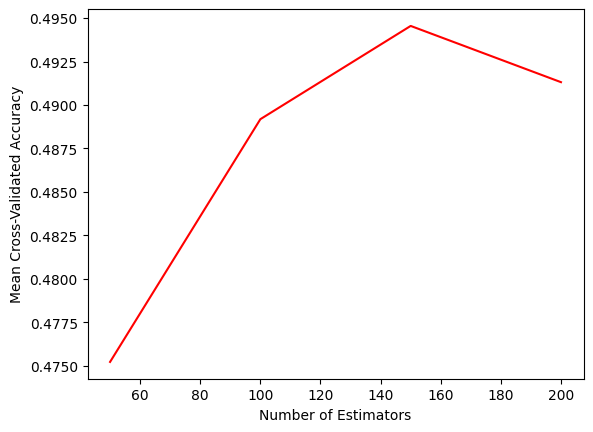

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(learning_rate=0.5, random_state=45)

acc_list = []
for num_estimators in [50, 100, 150, 200]:  # Adjust the range as per your needs

    ada_boost.set_params(n_estimators=num_estimators)
    acc = cross_val_score(ada_boost, X_train, y_train, cv=5).mean()
    acc_list.append(acc)

x = np.array([50, 100, 150, 200])  # Use the specific values you want to test
plt.plot(x, acc_list, 'r-')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.show()



**Feature engineering for test set(should be exatly the same as the procedure we did above to the test dataframe)**

In [ ]:
#remove 'price' column
target_var.remove('price')

In [ ]:
#drop some meaningless column of the test datafeam
df_test = df_test[target_var]

In [ ]:
# sentiment_score = []
# df_test['description']
# from nltk.sentiment import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

# # Assuming df_train is your DataFrame with a 'text_column' containing text data
# # Replace 'text_column' with the actual column name

# # Example: Fill NaN values with an empty string
# df_test['description'] = df_test['description'].fillna('')

# # Create a SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()

# # Function to calculate sentiment score using SentimentIntensityAnalyzer
# def calculate_sentiment(text):
#     return sia.polarity_scores(text)['compound']

# df_test['description_count'] = df_test['description'].apply(lambda x: len(x.split()))
# # Apply the function to create a new column 'sentiment_score'
# df_test['sentiment_score'] = df_test['description'].apply(calculate_sentiment)


In [ ]:
df_test = df_test.drop('description',axis=1)
#do the one-hot encoding for 'method' column for test dataframe
for method in methods:

    df_test[method] = df_test['host_verifications'].apply(lambda x: 1 if method in x else 0)

In [ ]:
#do the one-hot encoding for 'amenities' column for test dataframe
for attr in top_amenities:
    indicator = attr.replace(' ', '_').lower()
    df_test[indicator] = np.where(df_test['amenities'].str.contains(attr, case=False), 1, 0)
df_test['amenities_count'] = df_test['amenities'].apply(lambda x: len(eval(x)))
df_test = df_test.drop('amenities',axis = 1)

In [ ]:
#distinguish whether the house is studio or not for test dataframe
df_test['is_studio'] = df_test['name'].apply(lambda x: 1 if 'Studio' in x.split() else 0)
df_test = df_test.drop('host_verifications',axis = 1)

In [ ]:
#extract number of bedrooms from name column for test dataframe
bedroom_list = []
# Define expression pattern
pattern = r'(\d+)\s*bedrooms?'
for info in df_test['name'].values:

# Use re.search to find the match in the string
    match = re.search(pattern, info)

# If a match is found, extract the number of bedrooms
    if match:
        num_bedrooms = int(match.group(1))
    else:
        num_bedrooms = None

    bedroom_list.append(num_bedrooms)

df_test['num_bedrooms'] = bedroom_list
df_test['num_bedrooms'] = df_test['num_bedrooms'].fillna(0)

#extract star from name column for test dataframe
star_list = []
for info in df_test['name'].values:
    pattern = r'★([\d.]+)'
    match = re.search(pattern, info)
    if match:
        rating = match.group(1)
    else:
        rating = None
    star_list.append(rating)
df_test['star'] = star_list
df_test['star'].fillna(50,inplace = True) #fill none value with outlier 50
df_test = df_test.drop('name',axis = 1)

In [ ]:
#convert date-time data to the number of days since hosting for test dataframe
df_test['host_since'] = pd.to_datetime(df_test['host_since'])
target_date = pd.to_datetime('2023-12-2')
df_test['days_since_hosting'] = (target_date - df_test['host_since']).dt.days
df_test = df_test.drop(['host_since'],axis = 1)

In [ ]:
#extract 'shared_indicator' and number of baths from 'bathroom_txt' column for test dataframe
df_test['share_indicator'] = np.where(df_test['bathrooms_text'].str.contains('share', case=False), 1, 0)
df_test['num_baths'] = df_test['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
df_test['num_baths'] = df_test['num_baths'].fillna(0.5)
df_test = df_test.drop('bathrooms_text',axis=1)

In [ ]:
#do the one hot encoding for columns only contains 't' and 'f' for test dataframe
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_test['host_is_superhost'] = label_encoder.fit_transform(df_test['host_is_superhost'])
df_test['host_has_profile_pic']= label_encoder.fit_transform(df_test['host_has_profile_pic'])
df_test['host_identity_verified']= label_encoder.fit_transform(df_test['host_identity_verified'])
df_test['instant_bookable']= label_encoder.fit_transform(df_test['instant_bookable'])
df_test['has_availability']= label_encoder.fit_transform(df_test['has_availability'])

In [ ]:
#do the label encoding for 'room_type' 'neighbourhood_group_cleansed' 'neighbourhood_cleansed' and 'property_type' for test dataframe
df_test['room_type'] = df_test['room_type'].replace({'Entire home/apt': 4,'Hotel room': 3, 'Private room': 2,  'Shared room': 1})
df_test['neighbourhood_group_cleansed'] = df_test['neighbourhood_group_cleansed'].replace({'City of Los Angeles': 3, 'Other Cities': 2,'Unincorporated Areas':1})
df_test = df_test.drop('neighbourhood_group_cleansed',axis = 1)
df_test['neighbourhood_cleansed'] = df_test['neighbourhood_cleansed'].map(rank_by_neighbourhood)
df_test['property_type'] = df_test['property_type'].map(rank_by_proptype)

In [ ]:
#create 'distance_to_downtown' column for the test dataframe with the same methodology as in the train data frame
dis_list = []

for i, j in zip(df_test['latitude'], df_test['longitude']):
    point1 = np.array([i, j])  # Use parentheses here
    distance = np.linalg.norm(point1 - loc)
    dis_list.append(distance)

df_test['distance_to_downtown'] = dis_list

In [ ]:
#check null in test dataframe
df_test.isnull().sum()

host_id                                         0
property_type                                   7
neighbourhood_cleansed                          4
host_is_superhost                               0
host_has_profile_pic                            0
host_identity_verified                          0
room_type                                       0
accommodates                                    0
beds                                            0
latitude                                        0
longitude                                       0
host_listings_count                             0
has_availability                                0
instant_bookable                                0
number_of_reviews                               0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
minimum_nights                                  0


In [ ]:
df_test['neighbourhood_cleansed'].fillna(df_test['neighbourhood_cleansed'].median(),inplace = True)

In [ ]:
df_test['property_type'].fillna(df_test['property_type'].median(),inplace = True)

**apply model to the test set to submit**

In [ ]:
#check if the column diff is only the 'price'
difference1 = set(df_train.columns) - set(df_test.columns)
difference1

{'price'}

In [ ]:
#use fine-tuned model to predict output
predict_array = rf_model.predict(df_test)

In [ ]:
#use fine-tuned model to predict output
predict_array_ada = adaboost_model.predict(df_test)

In [ ]:
#check format
id_array = np.arange(6291)
df_sub_random_forest = pd.DataFrame(data={'id': id_array, 'price': predict_array})
df_sub_adaboost = pd.DataFrame(data={'id': id_array, 'price': predict_array_ada})
df_sub_random_forest

,id,price
0,0,3.0
1,1,2.0
2,2,3.0
3,3,4.0
4,4,2.0
...,...,...
6286,6286,5.0
6287,6287,5.0
6288,6288,2.0
6289,6289,0.0


In [ ]:
#download to submit
df_sub_random_forest.to_csv('output_file_random_forest.csv', index=False)
df_sub_adaboost.to_csv('output_file_adaboost.csv', index=False)
from google.colab import files
files.download('output_file_random_forest.csv')
files.download('output_file_adaboost.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

plot for comparasion

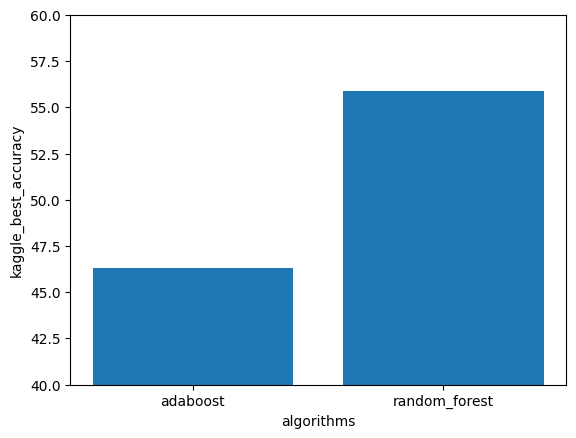

In [ ]:

acc_values = [46.282, 55.88]
labels = ['adaboost', 'random_forest']

# Plotting
plt.bar(labels, acc_values)
plt.xlabel('algorithms')
plt.ylabel('kaggle_best_accuracy')
plt.ylim(40,60)
plt.show()


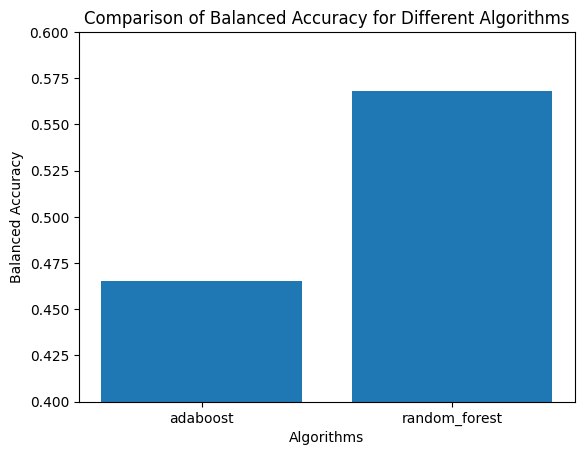

In [ ]:
#plot for comparasion of balanced accuracy of different algo
balanced_acc_adaboost = balanced_accuracy_score(y_test, y_test_pred_adaboost)
balanced_acc_randomforest = balanced_accuracy_score(y_test, y_test_pred)
acc_values = [balanced_acc_adaboost,balanced_acc_randomforest]

# Plotting
plt.bar(labels, acc_values)
plt.xlabel('Algorithms')
plt.ylabel('Balanced Accuracy')
plt.ylim(0.4, 0.6)
plt.title('Comparison of Balanced Accuracy for Different Algorithms')
plt.show()
